In [17]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import glob
import shutil

from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [7]:
#Pokemon dataset publicly available on Kaggle
#"https://www.kaggle.com/datasets/mikoajkolman/pokemon-images-first-generation17000-files/download?datasetVersionNumber=1"
#upload files into a new folder called 'pokemon'
#sub folders should be the names of pokemon and contain the associated images
root_path = "/content/pokemon"

In [15]:
poke = os.listdir(root_path)
poke.remove(".ipynb_checkpoints") #.ipynb_checkpoints appears at index 0 despite not appearing in colab files
print(poke)

['Alakazam', 'Abra', 'Aerodactyl']


In [18]:
for p in poke:
  image_path = os.path.join(root_path, p) #path of one pokemon folder
  image_list = glob.glob(image_path + "/*.jpg") #list of files in folder, uses only jpgs in this case
  train, val = image_list[:round(len(image_list) * 0.8)], image_list[round(len(image_list) * 0.8):] #80% for training, 20% for validation

  #for every image in the current pokemon folder designated for training
  for t in train:
    if not os.path.exists(os.path.join(root_path, "train", p)): #if the training folder hasnt been made
      os.makedirs(os.path.join(root_path, "train", p)) #make it
    shutil.move(t, os.path.join(root_path, "train", p)) #move the images

  #for every image in the current pokemon folder designated for validation
  for v in val:
    if not os.path.exists(os.path.join(root_path, "val", p)):
      os.makedirs(os.path.join(root_path, "val", p))
    shutil.move(v, os.path.join(root_path, "val", p))


In [19]:
#directory vars
train_path = os.path.join(root_path, "train")
val_path = os.path.join(root_path, "val")

In [20]:
batch_size = 10 #set the batch size
img_size = 150 #pixel width and length images will be normalized to

In [21]:
#Data Augmentation
image_gen_train = ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 45, #random rotation of 45 degrees
    zoom_range = 0.5, #random zoom of 50%
    horizontal_flip = True, #random horizontal flip
    width_shift_range = 0.15,
    height_shift_range = 0.15
)
train_data_gen = image_gen_train.flow_from_directory(batch_size = batch_size,
                                                     directory = train_path,
                                                     shuffle = True,
                                                     target_size = (img_size, img_size), #resize the image
                                                     class_mode = "sparse")

#val set does not need random transformations, and does not need shuffle
image_gen_val = ImageDataGenerator(rescale = 1./255)
val_data_gen = image_gen_val.flow_from_directory(batch_size = batch_size,
                                                 directory = val_path,
                                                 target_size = (img_size, img_size),
                                                 class_mode = "sparse")

Found 122 images belonging to 3 classes.
Found 30 images belonging to 3 classes.


In [22]:
num_of_pokemon = 3 #if using all examples in dataset, should be 143

#Create the model with nn layers to create CNN
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(16, (3,3), activation = "relu", input_shape = (150, 150, 3)), #16 filters, sized 3x3
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(32, (3,3), activation = "relu", input_shape = (150, 150, 3)), #increase filters to 32
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(64, (3,3), activation = "relu", input_shape = (150, 150, 3)), # to 64
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Dropout(0.2), #drop 20%
    tf.keras.layers.Flatten(), #flattens images
    tf.keras.layers.Dense(512, activation = "relu"),
    tf.keras.layers.Dense(num_of_pokemon, activation = "softmax") #softmax because outputs probability of several choices
])

In [23]:
model.compile(optimizer = "adam", loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True), metrics = ["accuracy"])

In [24]:
#Training the model
epochs = 80

history = model.fit_generator(train_data_gen, epochs = epochs, validation_data = val_data_gen)

Epoch 1/80


<ipython-input-24-637479fecee9>:4: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_data_gen, epochs = epochs, validation_data = val_data_gen)
/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5727: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


13/13 [==============================] - 8s 116ms/step - loss: 2.5211 - accuracy: 0.3279 - val_loss: 1.0100 - val_accuracy: 0.6000
Epoch 2/80
13/13 [==============================] - 1s 101ms/step - loss: 1.0160 - accuracy: 0.4754 - val_loss: 0.8908 - val_accuracy: 0.5333
Epoch 3/80
13/13 [==============================] - 1s 101ms/step - loss: 0.8780 - accuracy: 0.5984 - val_loss: 0.6145 - val_accuracy: 0.7333
Epoch 4/80
13/13 [==============================] - 1s 98ms/step - loss: 0.7039 - accuracy: 0.6885 - val_loss: 0.4872 - val_accuracy: 0.7000
Epoch 5/80
13/13 [==============================] - 2s 132ms/step - loss: 0.6112 - accuracy: 0.7049 - val_loss: 0.6179 - val_accuracy: 0.5667
Epoch 6/80
13/13 [==============================] - 2s 180ms/step - loss: 0.5870 - accuracy: 0.7295 - val_loss: 0.5553 - val_accuracy: 0.6000
Epoch 7/80
13/13 [==============================] - 1s 100ms/step - loss: 0.7398 - accuracy: 0.6475 - val_loss: 0.5079 - val_accuracy: 0.6667
Epoch 8/80
13/13 [

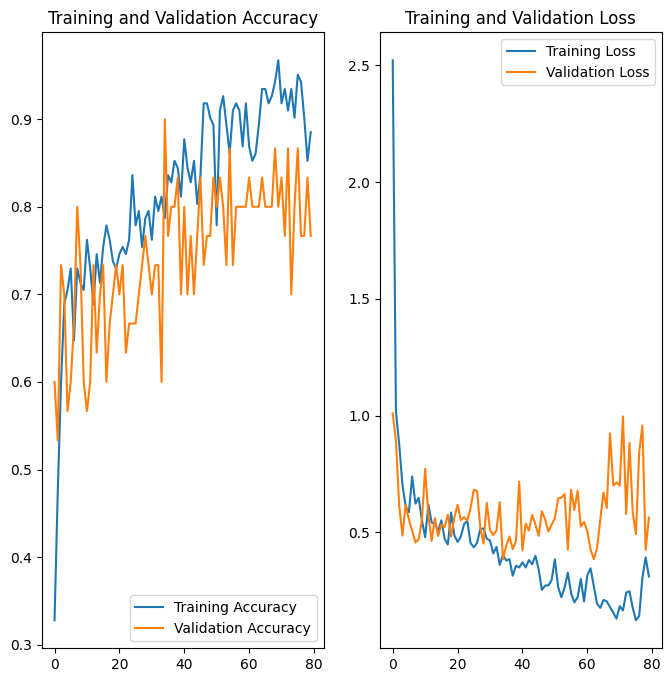

In [25]:
#plot code taken from online
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [27]:
#save model
model.save("pokemon_recognition_model.keras")